In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from datetime import datetime

# Veriyi okuma, yapısını inceleme , değerleri düzenleme

In [25]:
df = pd.read_csv("DailyDelhiClimateTest.csv")
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [26]:
df["date"] = pd.to_datetime(df["date"])

In [27]:
df = df.sort_values("date").reset_index(drop=True)

# Model eğitimi için hazırlık ve model eğitimleri

In [28]:
features = ["meantemp", "humidity", "wind_speed", "meanpressure"]

In [29]:
scaler = StandardScaler()

In [63]:
X = df[features].copy()
X_scaled = scaler.fit_transform(X)

# DBSCAN

In [33]:
dbscan = DBSCAN(eps=1.0, min_samples=5, metric="euclidean")
db_labels = dbscan.fit_predict(X_scaled)                   # -1=anomali, 0..=cluster
DBSCAN_label = (db_labels == -1).astype(int)

# LOF

In [34]:
lof = LocalOutlierFactor(n_neighbors=20, contamination="auto", novelty=False)
lof_labels = lof.fit_predict(X_scaled)                     # 1=normal, -1=anomali
LOF_label = (lof_labels == -1).astype(int)
LOF_score = -lof.negative_outlier_factor_    

# Isolation Forest

In [35]:
iforest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iforest.fit(X_scaled)
if_labels = iforest.predict(X_scaled)                      # 1=normal, -1=anomali
IF_label = (if_labels == -1).astype(int)
IF_score = -iforest.score_samples(X_scaled) 

# Sonuçlar

In [36]:
out = df[["date"]].copy()
out["DBSCAN_label"] = DBSCAN_label
out["LOF_label"] = LOF_label
out["IF_label"] = IF_label

In [37]:
out["vote"] = out[["DBSCAN_label","LOF_label","IF_label"]].sum(axis=1)
out["final_anomaly"] = (out["vote"] >= 2).astype(int)  

In [39]:
out["Anomaly_Status"] = np.where(out["final_anomaly"]==1, "Yüksek İhtimal Anomali", "Normal")
out

,date,DBSCAN_label,LOF_label,IF_label,vote,final_anomaly,Anomaly_Status
0,2017-01-01,1,1,1,3,1,Yüksek İhtimal Anomali
1,2017-01-02,0,0,0,0,0,Normal
2,2017-01-03,0,0,0,0,0,Normal
3,2017-01-04,0,0,0,0,0,Normal
4,2017-01-05,0,0,0,0,0,Normal
...,...,...,...,...,...,...,...
109,2017-04-20,0,0,1,1,0,Normal
110,2017-04-21,0,0,0,0,0,Normal
111,2017-04-22,0,0,0,0,0,Normal
112,2017-04-23,0,0,0,0,0,Normal


In [46]:
N = len(out)

def count_pct(col):
    c = out[col].value_counts().reindex([0,1], fill_value=0)
    return pd.DataFrame({
        "Class":[0,1],
        f"{col}_Count":[c[0], c[1]],
        f"{col}_Pct":[c[0]/N*100, c[1]/N*100]
    })

summary = (
    count_pct("DBSCAN_label")
    .join(count_pct("LOF_label").set_index("Class"), on="Class", rsuffix="_LOF")
    .join(count_pct("IF_label").set_index("Class"), on="Class", rsuffix="_IF")
)
summary

,Class,DBSCAN_label_Count,DBSCAN_label_Pct,LOF_label_Count,LOF_label_Pct,IF_label_Count,IF_label_Pct
0,0,111,97.368421,112,98.245614,108,94.736842
1,1,3,2.631579,2,1.754386,6,5.263158


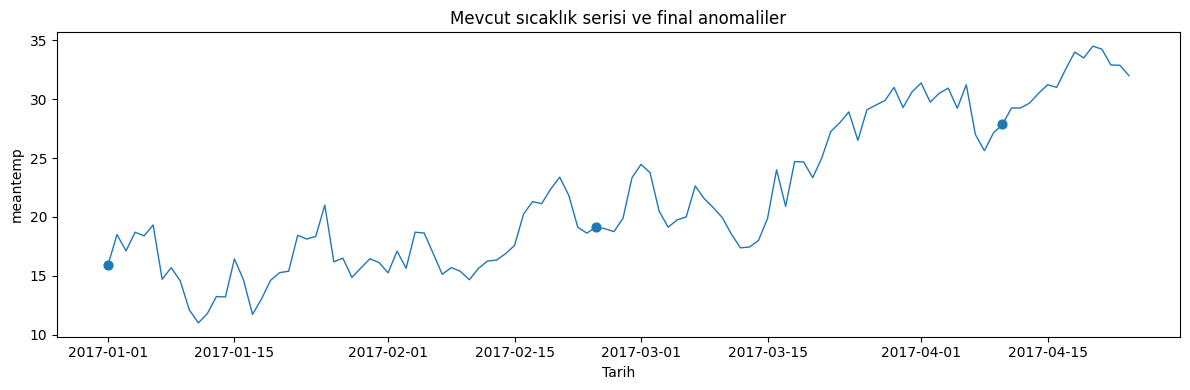

In [47]:
plt.figure(figsize=(12,4))
plt.plot(df["date"], df["meantemp"], lw=1)
anom_idx = out["final_anomaly"]==1
plt.scatter(df.loc[anom_idx,"date"], df.loc[anom_idx,"meantemp"], s=40)
plt.title("Mevcut sıcaklık serisi ve final anomaliler")
plt.xlabel("Tarih"); plt.ylabel("meantemp")
plt.tight_layout(); plt.show()

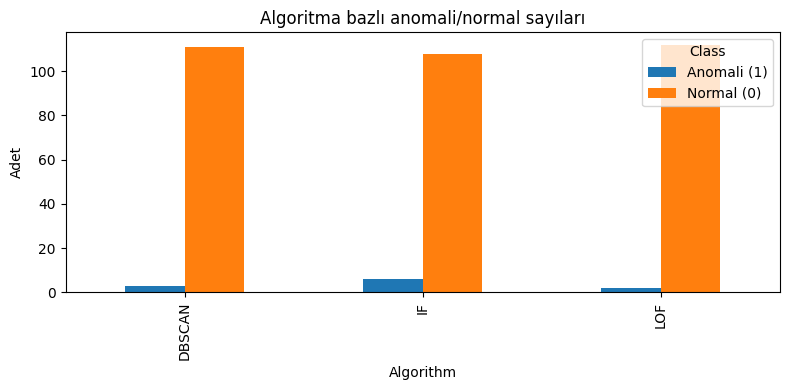

In [48]:
# Uzun form
rows = []
for algo in ["DBSCAN","LOF","IF"]:
    rows.append({"Algorithm":algo, "Class":"Normal (0)", "Count":int(out[f"{algo}_label"].value_counts().get(0,0))})
    rows.append({"Algorithm":algo, "Class":"Anomali (1)", "Count":int(out[f"{algo}_label"].value_counts().get(1,0))})
cmp_df = pd.DataFrame(rows)

# Gruplanmış bar
pivot = cmp_df.pivot(index="Algorithm", columns="Class", values="Count").fillna(0)
ax = pivot.plot(kind="bar", figsize=(8,4))
ax.set_ylabel("Adet")
ax.set_title("Algoritma bazlı anomali/normal sayıları")
plt.tight_layout(); plt.show()


In [49]:
anoms = out.loc[out["final_anomaly"]==1, ["date","DBSCAN_label","LOF_label","IF_label","vote","Anomaly_Status"]]
anoms


,date,DBSCAN_label,LOF_label,IF_label,vote,Anomaly_Status
0,2017-01-01,1,1,1,3,Yüksek İhtimal Anomali
54,2017-02-24,1,0,1,2,Yüksek İhtimal Anomali
99,2017-04-10,1,1,1,3,Yüksek İhtimal Anomali
